### Inference notebook:
- https://www.kaggle.com/code/ravaghi/isic-2024-swin-transformer-inference

# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import cv2
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_size = 224
    max_epochs = 50
    learning_rate = 1e-5
    weight_decay = 1e-6
    min_lr = 1e-10
    t_max = 1000
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "swin_base_patch4_window7_224"
    es_patience = 15

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

# Creating a custom image dataset

In [5]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [6]:
transforms = {
    'train': A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.5),
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ]),

    'val': A.Compose([
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ])
}

# Customizing the image model

In [7]:
class SwinTransformer(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(SwinTransformer, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.model.num_features * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Creating a trainer class

In [8]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            y_hat = self.model(x).squeeze()

            preds.extend(y_hat.detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

                self.optimizer.zero_grad()

                y_hat = self.model(x).squeeze()

                preds.extend(y_hat.detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device, dtype=torch.float)
                y_hat = model(x).squeeze()
                preds.extend(y_hat.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [9]:
histories = {}
oof_pred_probs_df = []
test_preds = []
for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    _train_positives = _train[_train.target == 1]
    _train_negatives = _train[_train.target == 0]
    _train = pd.concat([_train_positives, _train_negatives.sample(n=20 * len(_train_positives), random_state=CFG.seed)])
    _train = _train.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4, pin_memory=True)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    _val_positives = _val[_val.target == 1]
    _val_negatives = _val[_val.target == 0]
    _val = pd.concat([_val_positives, _val_negatives.sample(n=20 * len(_val_positives), random_state=CFG.seed)])
    _val = _val.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    _val_oof = train_metadata[train_metadata['fold'] == fold_idx]
    val_oof_dataset = ISICDataset(CFG.train_img_path, _val_oof, transforms['val'])
    val_oof_dataloader = DataLoader(val_oof_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    CFG.t_max = _train.shape[0] * (CFG.n_folds-1) * CFG.max_epochs // CFG.train_batch_size // CFG.n_folds

    model = SwinTransformer(CFG.model_name).to(CFG.device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_oof_dataloader)
    _val_oof[CFG.model_name] = pred_probs
    oof_pred_probs_df.append(_val_oof)

    del _train, _val, _val_oof, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 26/26 [00:11<00:00,  2.19it/s, val_loss=0.511]


Epoch 1: Train pAUC: 0.050212 - Val pAUC: 0.061066 | Train Loss: 20.552592 - Val Loss: 32.581442



Epoch 2: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.291]


New best model found: pAUC = 0.081639 (previous best: 0.061066)
Epoch 2: Train pAUC: 0.062353 - Val pAUC: 0.081639 | Train Loss: 14.300601 - Val Loss: 18.557488



Epoch 3: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.229]


New best model found: pAUC = 0.093092 (previous best: 0.081639)
Epoch 3: Train pAUC: 0.062438 - Val pAUC: 0.093092 | Train Loss: 10.058597 - Val Loss: 14.605235



Epoch 4: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.186]


Epoch 4: Train pAUC: 0.071442 - Val pAUC: 0.089458 | Train Loss: 7.517815 - Val Loss: 11.856162



Epoch 5: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.15]


Epoch 5: Train pAUC: 0.073606 - Val pAUC: 0.083455 | Train Loss: 6.519325 - Val Loss: 9.541587



Epoch 6: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.164]


New best model found: pAUC = 0.102168 (previous best: 0.093092)
Epoch 6: Train pAUC: 0.064783 - Val pAUC: 0.102168 | Train Loss: 6.000356 - Val Loss: 10.479238



Epoch 7: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s, val_loss=0.138]


Epoch 7: Train pAUC: 0.090019 - Val pAUC: 0.094414 | Train Loss: 5.198977 - Val Loss: 8.785572



Epoch 8: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s, val_loss=0.142]


Epoch 8: Train pAUC: 0.097772 - Val pAUC: 0.086747 | Train Loss: 5.029030 - Val Loss: 9.063874



Epoch 9: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.151]


New best model found: pAUC = 0.112807 (previous best: 0.102168)
Epoch 9: Train pAUC: 0.110435 - Val pAUC: 0.112807 | Train Loss: 4.710838 - Val Loss: 9.605000



Epoch 10: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.141]


Epoch 10: Train pAUC: 0.110592 - Val pAUC: 0.110115 | Train Loss: 4.559643 - Val Loss: 9.006226



Epoch 11: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.143]


Epoch 11: Train pAUC: 0.104054 - Val pAUC: 0.110309 | Train Loss: 4.193615 - Val Loss: 9.101969



Epoch 12: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s, val_loss=0.131]


Epoch 12: Train pAUC: 0.124030 - Val pAUC: 0.101779 | Train Loss: 4.011059 - Val Loss: 8.358750



Epoch 13: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.127]


Epoch 13: Train pAUC: 0.131782 - Val pAUC: 0.106235 | Train Loss: 3.870447 - Val Loss: 8.109815



Epoch 14: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.134]


New best model found: pAUC = 0.119470 (previous best: 0.112807)
Epoch 14: Train pAUC: 0.124004 - Val pAUC: 0.119470 | Train Loss: 3.687757 - Val Loss: 8.539247



Epoch 15: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.132]


New best model found: pAUC = 0.124097 (previous best: 0.119470)
Epoch 15: Train pAUC: 0.126176 - Val pAUC: 0.124097 | Train Loss: 3.604120 - Val Loss: 8.417101



Epoch 16: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.137]


Epoch 16: Train pAUC: 0.129977 - Val pAUC: 0.108652 | Train Loss: 3.401265 - Val Loss: 8.771842



Epoch 17: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.13]


Epoch 17: Train pAUC: 0.139846 - Val pAUC: 0.119787 | Train Loss: 3.345740 - Val Loss: 8.266369



Epoch 18: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.13]


Epoch 18: Train pAUC: 0.143560 - Val pAUC: 0.107896 | Train Loss: 3.066709 - Val Loss: 8.265856



Epoch 19: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.133]


Epoch 19: Train pAUC: 0.143124 - Val pAUC: 0.106313 | Train Loss: 2.935132 - Val Loss: 8.462645



Epoch 20: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.122]


Epoch 20: Train pAUC: 0.150034 - Val pAUC: 0.120155 | Train Loss: 2.882715 - Val Loss: 7.810787



Epoch 21: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.145]


Epoch 21: Train pAUC: 0.153243 - Val pAUC: 0.119406 | Train Loss: 2.685895 - Val Loss: 9.228716



Epoch 22: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.13]


Epoch 22: Train pAUC: 0.159412 - Val pAUC: 0.098411 | Train Loss: 2.567658 - Val Loss: 8.309549



Epoch 23: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.142]


Epoch 23: Train pAUC: 0.143541 - Val pAUC: 0.112017 | Train Loss: 2.686213 - Val Loss: 9.041602



Epoch 24: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.148]


New best model found: pAUC = 0.129003 (previous best: 0.124097)
Epoch 24: Train pAUC: 0.156003 - Val pAUC: 0.129003 | Train Loss: 2.522980 - Val Loss: 9.457127



Epoch 25: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.142]


Epoch 25: Train pAUC: 0.150717 - Val pAUC: 0.104523 | Train Loss: 2.417026 - Val Loss: 9.049774



Epoch 26: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.136]


Epoch 26: Train pAUC: 0.152621 - Val pAUC: 0.105055 | Train Loss: 2.361854 - Val Loss: 8.654178



Epoch 27: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.134]


Epoch 27: Train pAUC: 0.156725 - Val pAUC: 0.118422 | Train Loss: 2.731466 - Val Loss: 8.531695



Epoch 28: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.136]


Epoch 28: Train pAUC: 0.160787 - Val pAUC: 0.108539 | Train Loss: 2.354706 - Val Loss: 8.674229



Epoch 29: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.146]


Epoch 29: Train pAUC: 0.167789 - Val pAUC: 0.121000 | Train Loss: 2.155434 - Val Loss: 9.344424



Epoch 30: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s, val_loss=0.136]


Epoch 30: Train pAUC: 0.158364 - Val pAUC: 0.104124 | Train Loss: 2.280881 - Val Loss: 8.661675



Epoch 31: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.137]


Epoch 31: Train pAUC: 0.163537 - Val pAUC: 0.102331 | Train Loss: 2.243643 - Val Loss: 8.748659



Epoch 32: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.139]


Epoch 32: Train pAUC: 0.159389 - Val pAUC: 0.106502 | Train Loss: 2.302468 - Val Loss: 8.898677



Epoch 33: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.14]


Epoch 33: Train pAUC: 0.172910 - Val pAUC: 0.104443 | Train Loss: 1.979865 - Val Loss: 8.929343



Epoch 34: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.146]


Epoch 34: Train pAUC: 0.162376 - Val pAUC: 0.098378 | Train Loss: 2.138296 - Val Loss: 9.337980



Epoch 35: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.146]


Epoch 35: Train pAUC: 0.157895 - Val pAUC: 0.109805 | Train Loss: 2.081630 - Val Loss: 9.335440



Epoch 36: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.143]


Epoch 36: Train pAUC: 0.164384 - Val pAUC: 0.096414 | Train Loss: 2.126918 - Val Loss: 9.125330



Epoch 37: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.142]


Epoch 37: Train pAUC: 0.156858 - Val pAUC: 0.108907 | Train Loss: 2.250046 - Val Loss: 9.067390



Epoch 38: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s, val_loss=0.136]


Epoch 38: Train pAUC: 0.172356 - Val pAUC: 0.110683 | Train Loss: 2.047214 - Val Loss: 8.707849



Epoch 39: 100%|██████████| 26/26 [00:11<00:00,  2.27it/s, val_loss=0.142]


Early stopping triggered at epoch 39. Best pAUC = 0.129003
Epoch 39: Train pAUC: 0.164176 - Val pAUC: 0.109455 | Train Loss: 2.077051 - Val Loss: 9.040343



Prediction: 100%|██████████| 1211/1211 [08:20<00:00,  2.42it/s]


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.549]


Epoch 1: Train pAUC: 0.038898 - Val pAUC: 0.090223 | Train Loss: 22.063371 - Val Loss: 34.565660



Epoch 2: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.394]


New best model found: pAUC = 0.091614 (previous best: 0.090223)
Epoch 2: Train pAUC: 0.077442 - Val pAUC: 0.091614 | Train Loss: 16.397456 - Val Loss: 24.831766



Epoch 3: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.268]


Epoch 3: Train pAUC: 0.075528 - Val pAUC: 0.077739 | Train Loss: 11.559663 - Val Loss: 16.908193



Epoch 4: 100%|██████████| 22/22 [00:09<00:00,  2.28it/s, val_loss=0.232]


Epoch 4: Train pAUC: 0.066620 - Val pAUC: 0.088554 | Train Loss: 8.556437 - Val Loss: 14.632112



Epoch 5: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.208]


New best model found: pAUC = 0.105271 (previous best: 0.091614)
Epoch 5: Train pAUC: 0.073795 - Val pAUC: 0.105271 | Train Loss: 7.090825 - Val Loss: 13.110722



Epoch 6: 100%|██████████| 22/22 [00:09<00:00,  2.28it/s, val_loss=0.185]


Epoch 6: Train pAUC: 0.076652 - Val pAUC: 0.099548 | Train Loss: 6.256224 - Val Loss: 11.665038



Epoch 7: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.175]


New best model found: pAUC = 0.143455 (previous best: 0.105271)
Epoch 7: Train pAUC: 0.090304 - Val pAUC: 0.143455 | Train Loss: 5.736017 - Val Loss: 11.053973



Epoch 8: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, val_loss=0.153]


Epoch 8: Train pAUC: 0.094181 - Val pAUC: 0.099614 | Train Loss: 5.046547 - Val Loss: 9.648089



Epoch 9: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.148]


Epoch 9: Train pAUC: 0.093379 - Val pAUC: 0.142801 | Train Loss: 4.764829 - Val Loss: 9.341892



Epoch 10: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.166]


Epoch 10: Train pAUC: 0.096349 - Val pAUC: 0.112652 | Train Loss: 4.564924 - Val Loss: 10.438643



Epoch 11: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.151]


Epoch 11: Train pAUC: 0.099065 - Val pAUC: 0.111047 | Train Loss: 4.246441 - Val Loss: 9.510469



Epoch 12: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.142]


Epoch 12: Train pAUC: 0.117422 - Val pAUC: 0.135815 | Train Loss: 3.989867 - Val Loss: 8.915682



Epoch 13: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.137]


New best model found: pAUC = 0.150583 (previous best: 0.143455)
Epoch 13: Train pAUC: 0.121505 - Val pAUC: 0.150583 | Train Loss: 3.822322 - Val Loss: 8.660773



Epoch 14: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.137]


Epoch 14: Train pAUC: 0.119758 - Val pAUC: 0.124690 | Train Loss: 3.546636 - Val Loss: 8.599944



Epoch 15: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.143]


Epoch 15: Train pAUC: 0.121857 - Val pAUC: 0.101827 | Train Loss: 3.425206 - Val Loss: 9.007682



Epoch 16: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, val_loss=0.13]


New best model found: pAUC = 0.162821 (previous best: 0.150583)
Epoch 16: Train pAUC: 0.140626 - Val pAUC: 0.162821 | Train Loss: 3.208529 - Val Loss: 8.160838



Epoch 17: 100%|██████████| 22/22 [00:09<00:00,  2.28it/s, val_loss=0.132]


Epoch 17: Train pAUC: 0.137901 - Val pAUC: 0.136855 | Train Loss: 3.128435 - Val Loss: 8.306867



Epoch 18: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.124]


Epoch 18: Train pAUC: 0.140800 - Val pAUC: 0.157975 | Train Loss: 3.063960 - Val Loss: 7.798834



Epoch 19: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.127]


Epoch 19: Train pAUC: 0.143071 - Val pAUC: 0.143939 | Train Loss: 2.759753 - Val Loss: 7.992395



Epoch 20: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.129]


Epoch 20: Train pAUC: 0.160280 - Val pAUC: 0.145328 | Train Loss: 2.688556 - Val Loss: 8.129696



Epoch 21: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.131]


Epoch 21: Train pAUC: 0.159179 - Val pAUC: 0.133035 | Train Loss: 2.488094 - Val Loss: 8.259047



Epoch 22: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.139]


Epoch 22: Train pAUC: 0.160811 - Val pAUC: 0.144731 | Train Loss: 2.410997 - Val Loss: 8.740070



Epoch 23: 100%|██████████| 22/22 [00:09<00:00,  2.27it/s, val_loss=0.127]


Epoch 23: Train pAUC: 0.160054 - Val pAUC: 0.152982 | Train Loss: 2.353986 - Val Loss: 7.972450



Epoch 24: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.13]


Epoch 24: Train pAUC: 0.165521 - Val pAUC: 0.143522 | Train Loss: 2.160966 - Val Loss: 8.211110



Epoch 25: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, val_loss=0.147]


Epoch 25: Train pAUC: 0.170609 - Val pAUC: 0.136129 | Train Loss: 2.142943 - Val Loss: 9.260678



Epoch 26: 100%|██████████| 22/22 [00:09<00:00,  2.30it/s, val_loss=0.129]


Epoch 26: Train pAUC: 0.166285 - Val pAUC: 0.137482 | Train Loss: 2.119308 - Val Loss: 8.120542



Epoch 27: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.143]


Epoch 27: Train pAUC: 0.170649 - Val pAUC: 0.142837 | Train Loss: 2.072098 - Val Loss: 8.998428



Epoch 28: 100%|██████████| 22/22 [00:09<00:00,  2.28it/s, val_loss=0.134]


Epoch 28: Train pAUC: 0.167151 - Val pAUC: 0.141373 | Train Loss: 1.947068 - Val Loss: 8.444223



Epoch 29: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, val_loss=0.131]


Epoch 29: Train pAUC: 0.172827 - Val pAUC: 0.133618 | Train Loss: 1.915357 - Val Loss: 8.272230



Epoch 30: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s, val_loss=0.132]


Epoch 30: Train pAUC: 0.176238 - Val pAUC: 0.136056 | Train Loss: 1.897028 - Val Loss: 8.322872



Epoch 31: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, val_loss=0.131]


Early stopping triggered at epoch 31. Best pAUC = 0.162821
Epoch 31: Train pAUC: 0.175858 - Val pAUC: 0.145764 | Train Loss: 1.796923 - Val Loss: 8.250734



Prediction: 100%|██████████| 1310/1310 [09:01<00:00,  2.42it/s]


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.491]


Epoch 1: Train pAUC: 0.037379 - Val pAUC: 0.104811 | Train Loss: 19.691982 - Val Loss: 31.309786



Epoch 2: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.404]


New best model found: pAUC = 0.122602 (previous best: 0.104811)
Epoch 2: Train pAUC: 0.057826 - Val pAUC: 0.122602 | Train Loss: 15.274302 - Val Loss: 25.752780



Epoch 3: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.285]


New best model found: pAUC = 0.133917 (previous best: 0.122602)
Epoch 3: Train pAUC: 0.081883 - Val pAUC: 0.133917 | Train Loss: 11.962842 - Val Loss: 18.160096



Epoch 4: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.262]


Epoch 4: Train pAUC: 0.087932 - Val pAUC: 0.133352 | Train Loss: 9.487656 - Val Loss: 16.684491



Epoch 5: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.175]


New best model found: pAUC = 0.136286 (previous best: 0.133917)
Epoch 5: Train pAUC: 0.070834 - Val pAUC: 0.136286 | Train Loss: 7.598355 - Val Loss: 11.177880



Epoch 6: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.174]


Epoch 6: Train pAUC: 0.080361 - Val pAUC: 0.129662 | Train Loss: 6.361863 - Val Loss: 11.095238



Epoch 7: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.151]


New best model found: pAUC = 0.147651 (previous best: 0.136286)
Epoch 7: Train pAUC: 0.088736 - Val pAUC: 0.147651 | Train Loss: 5.771603 - Val Loss: 9.648042



Epoch 8: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.125]


New best model found: pAUC = 0.151446 (previous best: 0.147651)
Epoch 8: Train pAUC: 0.082152 - Val pAUC: 0.151446 | Train Loss: 5.160501 - Val Loss: 7.972780



Epoch 9: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.128]


Epoch 9: Train pAUC: 0.101951 - Val pAUC: 0.151099 | Train Loss: 4.816110 - Val Loss: 8.172852



Epoch 10: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.123]


Epoch 10: Train pAUC: 0.094349 - Val pAUC: 0.146852 | Train Loss: 4.714911 - Val Loss: 7.830288



Epoch 11: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.119]


Epoch 11: Train pAUC: 0.096468 - Val pAUC: 0.132426 | Train Loss: 4.562695 - Val Loss: 7.566450



Epoch 12: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.119]


New best model found: pAUC = 0.154330 (previous best: 0.151446)
Epoch 12: Train pAUC: 0.095532 - Val pAUC: 0.154330 | Train Loss: 4.270703 - Val Loss: 7.599838



Epoch 13: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.121]


Epoch 13: Train pAUC: 0.105641 - Val pAUC: 0.148042 | Train Loss: 3.985970 - Val Loss: 7.719239



Epoch 14: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.109]


Epoch 14: Train pAUC: 0.136787 - Val pAUC: 0.149787 | Train Loss: 3.554048 - Val Loss: 6.972715



Epoch 15: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.115]


Epoch 15: Train pAUC: 0.128418 - Val pAUC: 0.146185 | Train Loss: 3.523076 - Val Loss: 7.344583



Epoch 16: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.115]


New best model found: pAUC = 0.158849 (previous best: 0.154330)
Epoch 16: Train pAUC: 0.138962 - Val pAUC: 0.158849 | Train Loss: 3.350525 - Val Loss: 7.341666



Epoch 17: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.113]


Epoch 17: Train pAUC: 0.133524 - Val pAUC: 0.148281 | Train Loss: 3.058881 - Val Loss: 7.189130



Epoch 18: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.11]


Epoch 18: Train pAUC: 0.151744 - Val pAUC: 0.146627 | Train Loss: 2.986919 - Val Loss: 6.987347



Epoch 19: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.11]


Epoch 19: Train pAUC: 0.130168 - Val pAUC: 0.156206 | Train Loss: 3.073779 - Val Loss: 7.030247



Epoch 20: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.111]


Epoch 20: Train pAUC: 0.135823 - Val pAUC: 0.125730 | Train Loss: 2.878996 - Val Loss: 7.082347



Epoch 21: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.103]


New best model found: pAUC = 0.159985 (previous best: 0.158849)
Epoch 21: Train pAUC: 0.147719 - Val pAUC: 0.159985 | Train Loss: 2.828249 - Val Loss: 6.587915



Epoch 22: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.107]


Epoch 22: Train pAUC: 0.165237 - Val pAUC: 0.146249 | Train Loss: 2.513785 - Val Loss: 6.819143



Epoch 23: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.107]


Epoch 23: Train pAUC: 0.164347 - Val pAUC: 0.155201 | Train Loss: 2.343436 - Val Loss: 6.831079



Epoch 24: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.112]


Epoch 24: Train pAUC: 0.154426 - Val pAUC: 0.141767 | Train Loss: 2.235230 - Val Loss: 7.106390



Epoch 25: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.109]


Epoch 25: Train pAUC: 0.166150 - Val pAUC: 0.145832 | Train Loss: 2.132303 - Val Loss: 6.957713



Epoch 26: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.112]


Epoch 26: Train pAUC: 0.173287 - Val pAUC: 0.139861 | Train Loss: 2.098179 - Val Loss: 7.124132



Epoch 27: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.124]


Epoch 27: Train pAUC: 0.167124 - Val pAUC: 0.145743 | Train Loss: 1.960548 - Val Loss: 7.881404



Epoch 28: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.122]


Epoch 28: Train pAUC: 0.160512 - Val pAUC: 0.144370 | Train Loss: 2.045384 - Val Loss: 7.770154



Epoch 29: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.117]


Epoch 29: Train pAUC: 0.173307 - Val pAUC: 0.145125 | Train Loss: 1.932310 - Val Loss: 7.468121



Epoch 30: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.125]


New best model found: pAUC = 0.160597 (previous best: 0.159985)
Epoch 30: Train pAUC: 0.173072 - Val pAUC: 0.160597 | Train Loss: 1.807379 - Val Loss: 7.944548



Epoch 31: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.116]


Epoch 31: Train pAUC: 0.168297 - Val pAUC: 0.154148 | Train Loss: 1.874638 - Val Loss: 7.391240



Epoch 32: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.119]


Epoch 32: Train pAUC: 0.173741 - Val pAUC: 0.146763 | Train Loss: 1.839470 - Val Loss: 7.597256



Epoch 33: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.115]


Epoch 33: Train pAUC: 0.175495 - Val pAUC: 0.151411 | Train Loss: 1.705105 - Val Loss: 7.324737



Epoch 34: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.114]


Epoch 34: Train pAUC: 0.178447 - Val pAUC: 0.149092 | Train Loss: 1.757516 - Val Loss: 7.250641



Epoch 35: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.12]


Epoch 35: Train pAUC: 0.181724 - Val pAUC: 0.145634 | Train Loss: 1.611429 - Val Loss: 7.666175



Epoch 36: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.122]


Epoch 36: Train pAUC: 0.182254 - Val pAUC: 0.149189 | Train Loss: 1.617213 - Val Loss: 7.753465



Epoch 37: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.122]


Epoch 37: Train pAUC: 0.184859 - Val pAUC: 0.126635 | Train Loss: 1.625489 - Val Loss: 7.780444



Epoch 38: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.12]


Epoch 38: Train pAUC: 0.176070 - Val pAUC: 0.149607 | Train Loss: 1.658769 - Val Loss: 7.673128



Epoch 39: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.119]


Epoch 39: Train pAUC: 0.178685 - Val pAUC: 0.151130 | Train Loss: 1.698746 - Val Loss: 7.594459



Epoch 40: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.123]


Epoch 40: Train pAUC: 0.179804 - Val pAUC: 0.144974 | Train Loss: 1.650568 - Val Loss: 7.869141



Epoch 41: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.124]


Epoch 41: Train pAUC: 0.174058 - Val pAUC: 0.151052 | Train Loss: 1.614472 - Val Loss: 7.889943



Epoch 42: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.122]


Epoch 42: Train pAUC: 0.173077 - Val pAUC: 0.137785 | Train Loss: 1.606429 - Val Loss: 7.793908



Epoch 43: 100%|██████████| 29/29 [00:12<00:00,  2.29it/s, val_loss=0.12]


Epoch 43: Train pAUC: 0.180146 - Val pAUC: 0.150021 | Train Loss: 1.616642 - Val Loss: 7.660212



Epoch 44: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.121]


Epoch 44: Train pAUC: 0.177728 - Val pAUC: 0.142862 | Train Loss: 1.653475 - Val Loss: 7.736020



Epoch 45: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.126]


Early stopping triggered at epoch 45. Best pAUC = 0.160597
Epoch 45: Train pAUC: 0.175144 - Val pAUC: 0.147464 | Train Loss: 1.697635 - Val Loss: 8.056448



Prediction: 100%|██████████| 1191/1191 [08:12<00:00,  2.42it/s]


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 26/26 [00:11<00:00,  2.29it/s, val_loss=0.404]


Epoch 1: Train pAUC: 0.045575 - Val pAUC: 0.104152 | Train Loss: 17.536920 - Val Loss: 25.100760



Epoch 2: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.298]


Epoch 2: Train pAUC: 0.060316 - Val pAUC: 0.089491 | Train Loss: 12.755973 - Val Loss: 18.553679



Epoch 3: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.214]


New best model found: pAUC = 0.111749 (previous best: 0.104152)
Epoch 3: Train pAUC: 0.070826 - Val pAUC: 0.111749 | Train Loss: 9.378696 - Val Loss: 13.286872



Epoch 4: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.172]


Epoch 4: Train pAUC: 0.065981 - Val pAUC: 0.089469 | Train Loss: 7.408456 - Val Loss: 10.670621



Epoch 5: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.144]


New best model found: pAUC = 0.123282 (previous best: 0.111749)
Epoch 5: Train pAUC: 0.073883 - Val pAUC: 0.123282 | Train Loss: 6.576232 - Val Loss: 8.979739



Epoch 6: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.146]


Epoch 6: Train pAUC: 0.083227 - Val pAUC: 0.100916 | Train Loss: 5.767037 - Val Loss: 9.075722



Epoch 7: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.138]


New best model found: pAUC = 0.147435 (previous best: 0.123282)
Epoch 7: Train pAUC: 0.082927 - Val pAUC: 0.147435 | Train Loss: 5.292064 - Val Loss: 8.571005



Epoch 8: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.125]


Epoch 8: Train pAUC: 0.096108 - Val pAUC: 0.137064 | Train Loss: 4.768813 - Val Loss: 7.781211



Epoch 9: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.121]


New best model found: pAUC = 0.154228 (previous best: 0.147435)
Epoch 9: Train pAUC: 0.102198 - Val pAUC: 0.154228 | Train Loss: 4.352384 - Val Loss: 7.544572



Epoch 10: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.117]


Epoch 10: Train pAUC: 0.103104 - Val pAUC: 0.130305 | Train Loss: 4.201423 - Val Loss: 7.250823



Epoch 11: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.115]


Epoch 11: Train pAUC: 0.117659 - Val pAUC: 0.153143 | Train Loss: 3.988940 - Val Loss: 7.161970



Epoch 12: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.11]


New best model found: pAUC = 0.164389 (previous best: 0.154228)
Epoch 12: Train pAUC: 0.121756 - Val pAUC: 0.164389 | Train Loss: 3.740754 - Val Loss: 6.823794



Epoch 13: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.132]


Epoch 13: Train pAUC: 0.128299 - Val pAUC: 0.159916 | Train Loss: 3.484337 - Val Loss: 8.207551



Epoch 14: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.105]


Epoch 14: Train pAUC: 0.127814 - Val pAUC: 0.137173 | Train Loss: 3.469181 - Val Loss: 6.530335



Epoch 15: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.101]


Epoch 15: Train pAUC: 0.146576 - Val pAUC: 0.145460 | Train Loss: 3.080044 - Val Loss: 6.264464



Epoch 16: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.11]


Epoch 16: Train pAUC: 0.149699 - Val pAUC: 0.160970 | Train Loss: 2.962571 - Val Loss: 6.850462



Epoch 17: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.0999]


Epoch 17: Train pAUC: 0.156869 - Val pAUC: 0.163663 | Train Loss: 2.858639 - Val Loss: 6.215077



Epoch 18: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.104]


New best model found: pAUC = 0.167431 (previous best: 0.164389)
Epoch 18: Train pAUC: 0.139272 - Val pAUC: 0.167431 | Train Loss: 2.739743 - Val Loss: 6.482525



Epoch 19: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s, val_loss=0.112]


Epoch 19: Train pAUC: 0.157434 - Val pAUC: 0.154635 | Train Loss: 2.579850 - Val Loss: 6.948585



Epoch 20: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.105]


Epoch 20: Train pAUC: 0.159061 - Val pAUC: 0.161670 | Train Loss: 2.516797 - Val Loss: 6.544352



Epoch 21: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.108]


Epoch 21: Train pAUC: 0.150443 - Val pAUC: 0.121884 | Train Loss: 2.296428 - Val Loss: 6.711072



Epoch 22: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.109]


Epoch 22: Train pAUC: 0.166079 - Val pAUC: 0.152554 | Train Loss: 2.163877 - Val Loss: 6.786475



Epoch 23: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.112]


Epoch 23: Train pAUC: 0.166769 - Val pAUC: 0.132306 | Train Loss: 2.229841 - Val Loss: 6.994673



Epoch 24: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s, val_loss=0.106]


Epoch 24: Train pAUC: 0.167578 - Val pAUC: 0.152879 | Train Loss: 2.130955 - Val Loss: 6.579548



Epoch 25: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.116]


Epoch 25: Train pAUC: 0.175907 - Val pAUC: 0.119413 | Train Loss: 1.939742 - Val Loss: 7.185507



Epoch 26: 100%|██████████| 26/26 [00:11<00:00,  2.26it/s, val_loss=0.113]


Epoch 26: Train pAUC: 0.172970 - Val pAUC: 0.147868 | Train Loss: 1.944997 - Val Loss: 7.020423



Epoch 27: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.113]


Epoch 27: Train pAUC: 0.170025 - Val pAUC: 0.152272 | Train Loss: 1.861766 - Val Loss: 7.009249



Epoch 28: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.117]


Epoch 28: Train pAUC: 0.172635 - Val pAUC: 0.125940 | Train Loss: 1.698967 - Val Loss: 7.248151



Epoch 29: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.108]


Epoch 29: Train pAUC: 0.174917 - Val pAUC: 0.138595 | Train Loss: 1.766499 - Val Loss: 6.703004



Epoch 30: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.113]


Epoch 30: Train pAUC: 0.174555 - Val pAUC: 0.125920 | Train Loss: 1.766705 - Val Loss: 7.025713



Epoch 31: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s, val_loss=0.116]


Epoch 31: Train pAUC: 0.176384 - Val pAUC: 0.108732 | Train Loss: 1.570249 - Val Loss: 7.189679



Epoch 32: 100%|██████████| 26/26 [00:11<00:00,  2.31it/s, val_loss=0.118]


Epoch 32: Train pAUC: 0.180702 - Val pAUC: 0.131558 | Train Loss: 1.438644 - Val Loss: 7.340654



Epoch 33: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, val_loss=0.115]


Early stopping triggered at epoch 33. Best pAUC = 0.167431
Epoch 33: Train pAUC: 0.180815 - Val pAUC: 0.138882 | Train Loss: 1.516263 - Val Loss: 7.156393



Prediction: 100%|██████████| 1167/1167 [08:02<00:00,  2.42it/s]


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s, val_loss=0.526]


Epoch 1: Train pAUC: 0.039529 - Val pAUC: 0.123532 | Train Loss: 19.641891 - Val Loss: 32.747965



Epoch 2: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s, val_loss=0.418]


New best model found: pAUC = 0.135046 (previous best: 0.123532)
Epoch 2: Train pAUC: 0.075383 - Val pAUC: 0.135046 | Train Loss: 14.908652 - Val Loss: 26.009766



Epoch 3: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s, val_loss=0.243]


Epoch 3: Train pAUC: 0.079208 - Val pAUC: 0.129509 | Train Loss: 11.465742 - Val Loss: 15.132430



Epoch 4: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.172]


Epoch 4: Train pAUC: 0.067190 - Val pAUC: 0.099254 | Train Loss: 8.701752 - Val Loss: 10.683976



Epoch 5: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s, val_loss=0.151]


Epoch 5: Train pAUC: 0.079279 - Val pAUC: 0.128306 | Train Loss: 6.890784 - Val Loss: 9.409487



Epoch 6: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s, val_loss=0.134]


New best model found: pAUC = 0.137135 (previous best: 0.135046)
Epoch 6: Train pAUC: 0.075723 - Val pAUC: 0.137135 | Train Loss: 6.106983 - Val Loss: 8.317252



Epoch 7: 100%|██████████| 28/28 [00:11<00:00,  2.33it/s, val_loss=0.132]


Epoch 7: Train pAUC: 0.078249 - Val pAUC: 0.123477 | Train Loss: 5.456874 - Val Loss: 8.186388



Epoch 8: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.116]


New best model found: pAUC = 0.150433 (previous best: 0.137135)
Epoch 8: Train pAUC: 0.088767 - Val pAUC: 0.150433 | Train Loss: 5.067160 - Val Loss: 7.237013



Epoch 9: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.111]


New best model found: pAUC = 0.156881 (previous best: 0.150433)
Epoch 9: Train pAUC: 0.094888 - Val pAUC: 0.156881 | Train Loss: 4.586440 - Val Loss: 6.939263



Epoch 10: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.112]


Epoch 10: Train pAUC: 0.092219 - Val pAUC: 0.153540 | Train Loss: 4.608731 - Val Loss: 6.971772



Epoch 11: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.104]


Epoch 11: Train pAUC: 0.095372 - Val pAUC: 0.154342 | Train Loss: 4.297689 - Val Loss: 6.454146



Epoch 12: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.0984]


New best model found: pAUC = 0.161200 (previous best: 0.156881)
Epoch 12: Train pAUC: 0.113990 - Val pAUC: 0.161200 | Train Loss: 3.971351 - Val Loss: 6.126373



Epoch 13: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s, val_loss=0.112]


Epoch 13: Train pAUC: 0.104794 - Val pAUC: 0.128940 | Train Loss: 4.002018 - Val Loss: 6.958619



Epoch 14: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.1]


Epoch 14: Train pAUC: 0.118913 - Val pAUC: 0.158258 | Train Loss: 3.759924 - Val Loss: 6.229546



Epoch 15: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s, val_loss=0.103]


Epoch 15: Train pAUC: 0.114605 - Val pAUC: 0.151679 | Train Loss: 3.553856 - Val Loss: 6.437270



Epoch 16: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.101]


Epoch 16: Train pAUC: 0.134055 - Val pAUC: 0.158453 | Train Loss: 3.345819 - Val Loss: 6.273206



Epoch 17: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s, val_loss=0.103]


New best model found: pAUC = 0.167833 (previous best: 0.161200)
Epoch 17: Train pAUC: 0.127797 - Val pAUC: 0.167833 | Train Loss: 3.333275 - Val Loss: 6.435755



Epoch 18: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.1]


Epoch 18: Train pAUC: 0.133643 - Val pAUC: 0.152855 | Train Loss: 3.160448 - Val Loss: 6.249810



Epoch 19: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s, val_loss=0.0958]


New best model found: pAUC = 0.169019 (previous best: 0.167833)
Epoch 19: Train pAUC: 0.125127 - Val pAUC: 0.169019 | Train Loss: 3.168506 - Val Loss: 5.961680



Epoch 20: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s, val_loss=0.101]


New best model found: pAUC = 0.169827 (previous best: 0.169019)
Epoch 20: Train pAUC: 0.134725 - Val pAUC: 0.169827 | Train Loss: 2.921580 - Val Loss: 6.308802



Epoch 21: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0981]


Epoch 21: Train pAUC: 0.145171 - Val pAUC: 0.152304 | Train Loss: 2.742818 - Val Loss: 6.104789



Epoch 22: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0978]


Epoch 22: Train pAUC: 0.136969 - Val pAUC: 0.156629 | Train Loss: 2.763406 - Val Loss: 6.090011



Epoch 23: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0989]


Epoch 23: Train pAUC: 0.149845 - Val pAUC: 0.140171 | Train Loss: 2.532145 - Val Loss: 6.154090



Epoch 24: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0973]


Epoch 24: Train pAUC: 0.152985 - Val pAUC: 0.154676 | Train Loss: 2.421084 - Val Loss: 6.059555



Epoch 25: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s, val_loss=0.0935]


Epoch 25: Train pAUC: 0.140864 - Val pAUC: 0.138248 | Train Loss: 2.555551 - Val Loss: 5.821497



Epoch 26: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s, val_loss=0.094]


Epoch 26: Train pAUC: 0.150447 - Val pAUC: 0.158978 | Train Loss: 2.372612 - Val Loss: 5.851556



Epoch 27: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s, val_loss=0.0996]


Epoch 27: Train pAUC: 0.142669 - Val pAUC: 0.160398 | Train Loss: 2.352777 - Val Loss: 6.202617



Epoch 28: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.094]


Epoch 28: Train pAUC: 0.149858 - Val pAUC: 0.159435 | Train Loss: 2.330418 - Val Loss: 5.849321



Epoch 29: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0941]


Epoch 29: Train pAUC: 0.159199 - Val pAUC: 0.161491 | Train Loss: 2.125738 - Val Loss: 5.859585



Epoch 30: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s, val_loss=0.098]


Epoch 30: Train pAUC: 0.154027 - Val pAUC: 0.155862 | Train Loss: 2.170482 - Val Loss: 6.102855



Epoch 31: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0966]


Epoch 31: Train pAUC: 0.158354 - Val pAUC: 0.142352 | Train Loss: 2.091384 - Val Loss: 6.011021



Epoch 32: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0957]


Epoch 32: Train pAUC: 0.171350 - Val pAUC: 0.151086 | Train Loss: 1.971734 - Val Loss: 5.957806



Epoch 33: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.097]


Epoch 33: Train pAUC: 0.169106 - Val pAUC: 0.153302 | Train Loss: 1.957805 - Val Loss: 6.039663



Epoch 34: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s, val_loss=0.0998]


Epoch 34: Train pAUC: 0.171915 - Val pAUC: 0.154069 | Train Loss: 1.915010 - Val Loss: 6.212746



Epoch 35: 100%|██████████| 28/28 [00:11<00:00,  2.33it/s, val_loss=0.0989]


Early stopping triggered at epoch 35. Best pAUC = 0.169827
Epoch 35: Train pAUC: 0.162401 - Val pAUC: 0.159074 | Train Loss: 1.991978 - Val Loss: 6.154531



Prediction: 100%|██████████| 1389/1389 [09:34<00:00,  2.42it/s]


In [10]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', CFG.model_name]]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,swin_base_patch4_window7_224
10,ISIC_0051812,0.0,0,0.008632
18,ISIC_0052026,0.0,0,0.129371
30,ISIC_0052259,0.0,0,0.058466
32,ISIC_0052310,0.0,0,0.008232
33,ISIC_0052313,0.0,0,0.007417


# Results

In [11]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

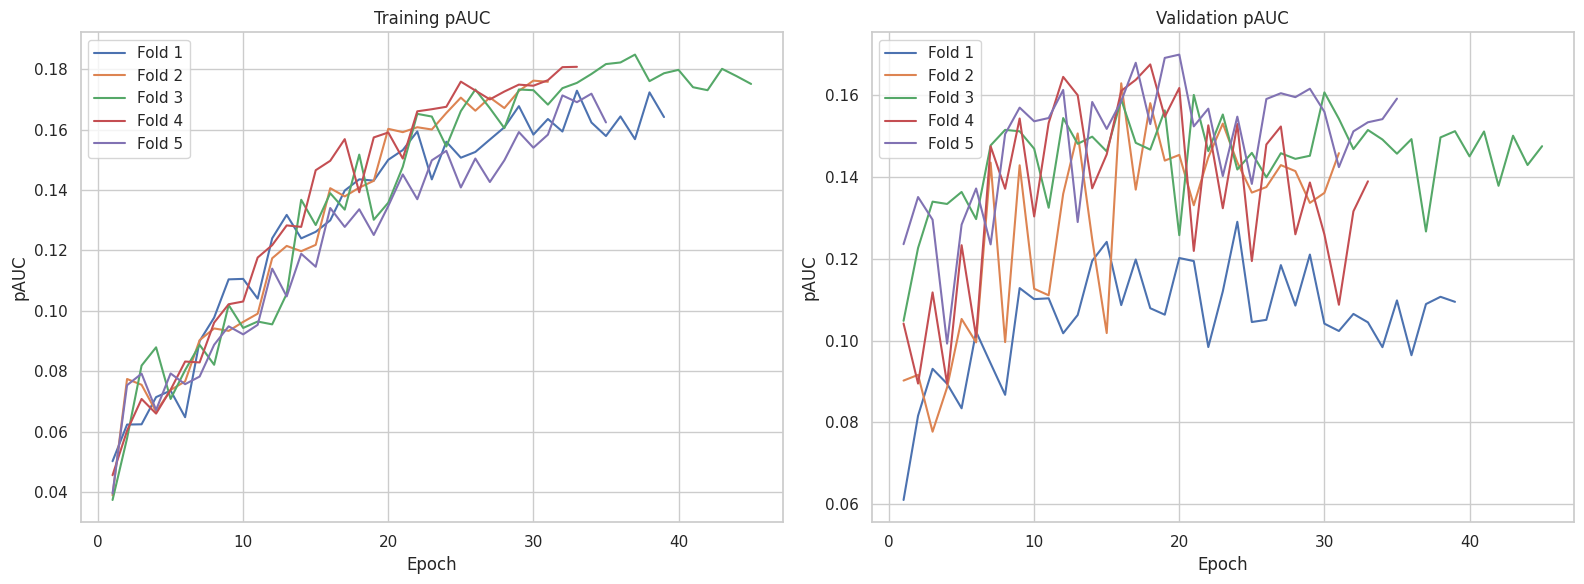

In [12]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

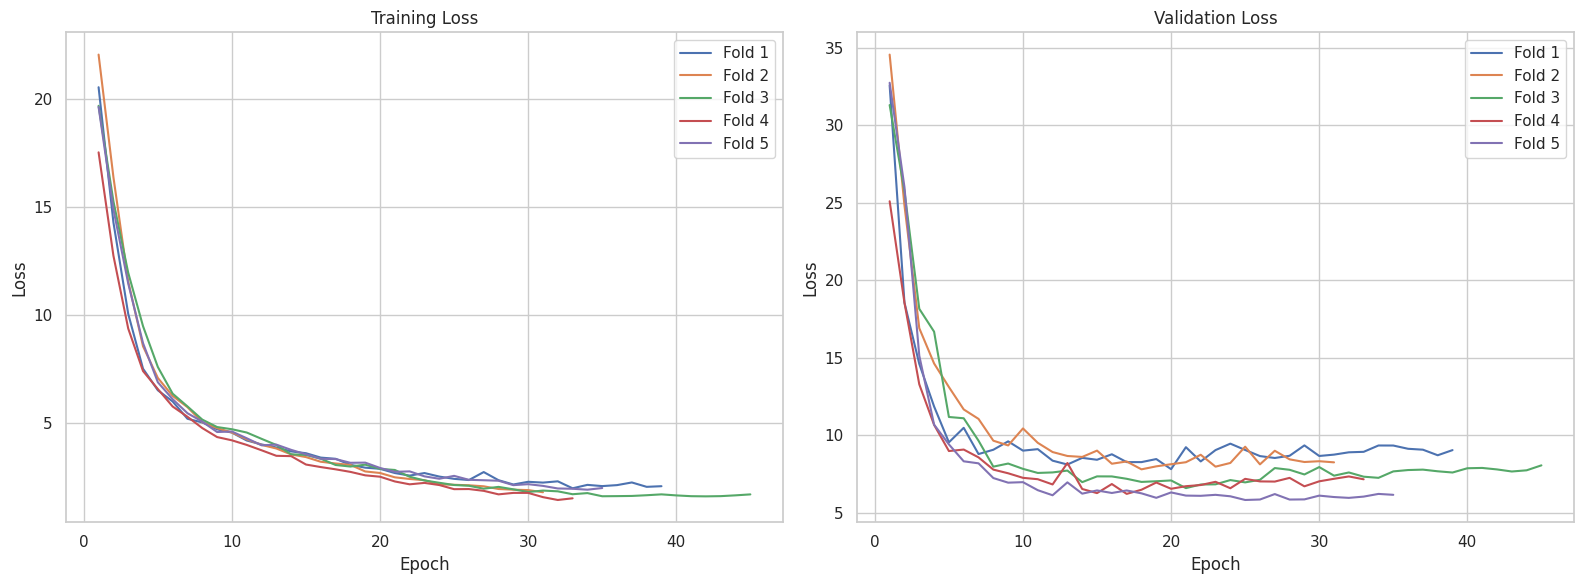

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()